Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: Sunday, December 17 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Dies Natalis Solis Invicti ([CET](https://en.wikipedia.org/wiki/Sol_Invictus))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [791]:
import numpy as np
import matplotlib.pylab as plt
import copy
import hashlib
from tqdm import tqdm

In [792]:
board = [['.' for _ in range(3)] for _ in range(3)]

In [793]:
# def make_move(i, j, player, board):
#     board[i][j] = 'o' if player else 'x'   
#     return board 


In [820]:
class game:
    def __init__(self, player1, player2):
        self.board = [['.' for _ in range(3)] for _ in range(3)]
        self.player1 = player1
        self.player2 = player2
        
    def is_win_for_player(self, player,board):
        player_value = 'o' if player else 'x'
        for i in range(3):
            number_of_tiles_columns = 0
            number_of_tiles_rows = 0
            for j in range(3): 
                if(board[i][j] == player_value):
                    number_of_tiles_rows += 1
                if(board[j][i] == player_value):
                    number_of_tiles_columns += 1
            if (number_of_tiles_rows == 3 or number_of_tiles_columns == 3):
                return True
        diag_count1 = 0
        diag_count2 = 0
        for i in range(3):
            j = 2-i
            if (board[i][i] == player_value):
                diag_count1 += 1
            if (board[i][j] == player_value):
                diag_count2 += 1
        if (diag_count1 == 3 or diag_count2 == 3):
            return True
        return False
    
    def get_legal_moves(self):
        legal_moves = []
        for i in range(3):
            for j in range(3):
                if (self.board[i][j] == '.'):
                    legal_moves.append((i,j))
        return legal_moves


    def set_position(self, board):
        self.board = board

    def make_move(self, i, j, value):
        self.board[i][j] = value
        value = self.evaluate_position(board)
        self.player1.add_state(self.board)
        self.player2.add_state(self.board)
        if (value == 'x'):
            #print("Player x won!")
            self.player1.update_reward(1)
            self.player2.update_reward(-1)
        if (value == 'o'):
            #print("Player o won!")
            self.player1.update_reward(-1)
            self.player2.update_reward(-1)
        if(value == 't'):
            #print("Its was a tie")
            self.player1.update_reward(0)
            self.player2.update_reward(0)
        if(value != 'u'):
            #print("they learn!")
            self.player1.game_num += 1
            self.player2.game_num += 1
            self.player1.learn()
            self.player2.learn()
            
        return self.board 
    
    def evaluate_position(self, baord):
        p1_value = 'x'
        p2_value = 'o'
        for i in range(3):
            number_of_tiles_columns_p1 = 0
            number_of_tiles_columns_p2 = 0
            number_of_tiles_rows_p1 = 0
            number_of_tiles_rows_p2 = 0
            for j in range(3): 
                if(self.board[i][j] == p1_value):
                    number_of_tiles_rows_p1 += 1
                if(self.board[j][i] == p1_value):
                    number_of_tiles_columns_p1 += 1
                if(self.board[i][j] == p2_value):
                    number_of_tiles_rows_p2 += 1
                if(self.board[j][i] == p2_value):
                    number_of_tiles_columns_p2 += 1
            if (number_of_tiles_rows_p1 == 3 or number_of_tiles_columns_p1 == 3):
                return p1_value
            if (number_of_tiles_rows_p2 == 3 or number_of_tiles_columns_p2 == 3):
                return p2_value
        diag_count1_p1 = 0
        diag_count1_p2 = 0
        diag_count2_p1 = 0
        diag_count2_p2 = 0
        for i in range(3):
            j = 2-i
            if (self.board[i][i] == p1_value):
                diag_count1_p1 += 1
            if (self.board[i][j] == p1_value):
                diag_count2_p1 += 1
            if (self.board[i][i] == p2_value):
                diag_count1_p2 += 1
            if (self.board[i][j] == p2_value):
                diag_count2_p2 += 1
        if (diag_count1_p1 == 3 or diag_count2_p1 == 3):
            return p1_value
        if (diag_count1_p2 == 3 or diag_count2_p2 == 3):
            return p2_value
        
        if (len(self.get_legal_moves()) == 0):
            return 't'
        
        return 'u'


    def play_game(self, print_game):
        board_eval = self.evaluate_position(self.board)
        player_num = 0
        self.player1.add_state(self.board)
        self.player2.add_state(self.board)
        i = 0
        while board_eval == 'u' and i < 20:
            player = self.player1 if player_num == 0 else self.player2
            i, j = player.get_move(self)
            self.make_move(i,j,player.player_symbol)
            player_num = 1-player_num
            board_eval = self.evaluate_position(self.board)
            if (print_game):
                print(hash(str(self.board)))
                for row in self.board:
                    print(row)
                print("\n")
        if (print_game):
            print(f"result: {self.evaluate_position(self.board)}")
            i += 1

In [902]:
class agent:
    def __init__(self, learning_rate, num_games, gamma, player_num):
        self.board_states = []
        self.learning_rate = learning_rate
        self.state_values = {}
        self.game_num = 0
        self.num_games = num_games
        self.player_num = player_num
        self.player_symbol = 'o' if player_num else 'x'
        self.game_reward = None
        self.gamma = gamma
    

    def get_move(self, g):
        #self.board_states.append(hash(str(game.board)))
        exploration_rate = 1 - np.log2(1 + self.game_num / self.num_games)
        if(np.random.random() <= exploration_rate):
            new_move = g.get_legal_moves()[np.random.randint(0,len(g.get_legal_moves()))]
            #new_position = game.make_move(new_move[0], new_move[1], self.player_num)
            #self.board_states.append(hash(str(new_position)))
            #print(f"legal moves: {g.get_legal_moves()}")
            return new_move

        else:
            highest_value = -np.inf
            best_p = None
            for p in g.get_legal_moves():
                current_board = copy.deepcopy(g.board)
                game_to_evaluate = copy.deepcopy(g)
                game_to_evaluate.set_position(current_board)
                #print(f"current board: {current_board}")
                game_to_evaluate.set_position(current_board)
                game_to_evaluate.make_move(p[0], p[1], self.player_symbol)
                new_board = game_to_evaluate.board
                #print(f"new board: {new_board}")
                new_value = 0 if self.state_values.get(hash(str(new_board))) == None else self.state_values.get(hash(str(new_board)))
                #print(f"new value: {new_value}")
                if (new_value > highest_value):
                    highest_value = new_value
                    best_p = p
            #print(f"highest value: {highest_value}")
            return best_p
                    
    def add_state(self, state):
        self.board_states.append(hash(str(state)))

    def update_reward(self, reward):
        self.game_reward = reward

    def learn(self):
        for state in reversed(self.board_states):
            if (self.state_values.get(state) == None):
                self.state_values[state] = 0
            self.state_values[state] += self.learning_rate * (self.gamma * self.game_reward - self.state_values[state])
            self.game_reward = self.state_values[state]
        self.reward = None
        self.board_states.clear()
        


In [903]:
# a3 = agent(0.4, 0.3, 0.9, 0)
# a4 = agent(0.4, 0.3, 0.9, 1)

# g2= game(a3, a4)

In [907]:
num_games = 10001
a1 = agent(0.5, num_games, 0.8, 0)
a2 = agent(0.5, num_games, 0.8, 1)
g = game(a1, a2)
print(a1.state_values)
print(a2.state_values)

{}
{}


In [908]:
def simulate(agent1, agent2, number_of_games):
    for i in tqdm(range(number_of_games)):
        if (i == number_of_games-1):
            agent1.exploration_rate = 0
            agent2.exploration_rate = 0
        g = game(agent1, agent2)
        if(i % 1000 == 0):
            g.play_game(False)
        else:
            g.play_game(False)

In [909]:
simulate(a1, a2, num_games)

100%|██████████| 10001/10001 [19:06<00:00,  8.72it/s]


In [910]:
print(len(a1.state_values))

5354


In [911]:
class play_game:
    def __init__(self, agent: agent):
        self.board = [['.' for _ in range(3)] for _ in range(3)]
        self.agent = agent
    

    
    def get_legal_moves(self):
        legal_moves = []
        for i in range(3):
            for j in range(3):
                if (self.board[i][j] == '.'):
                    legal_moves.append((i,j))
        return legal_moves

    def make_move(self, i, j, player):
        value = 'o' if player == "agent" else 'x'
        self.board[i][j] = value
        #print(f"{player} played {value} in position {i,j}")
        value = self.evaluate_position()
        if (value == 'x'):
            print("Player x won!")
            
        if (value == 'o'):
            print("Player o won!")
        
        if(value == 't'):
            print("Its was a tie")
        return board 
    
    def evaluate_position(self):
        p1_value = 'x'
        p2_value = 'o'

        
        # for row in self.board:
        #     print(row)
        # print("\n")


        for i in range(3):
            number_of_tiles_columns_p1 = 0
            number_of_tiles_columns_p2 = 0
            number_of_tiles_rows_p1 = 0
            number_of_tiles_rows_p2 = 0
            for j in range(3): 
                if(self.board[i][j] == p1_value):
                    number_of_tiles_rows_p1 += 1
                if(self.board[j][i] == p1_value):
                    number_of_tiles_columns_p1 += 1
                if(self.board[i][j] == p2_value):
                    number_of_tiles_rows_p2 += 1
                if(self.board[j][i] == p2_value):
                    number_of_tiles_columns_p2 += 1
            if (number_of_tiles_rows_p1 == 3 or number_of_tiles_columns_p1 == 3):
                return p1_value
            if (number_of_tiles_rows_p2 == 3 or number_of_tiles_columns_p2 == 3):
                return p2_value
        diag_count1_p1 = 0
        diag_count1_p2 = 0
        diag_count2_p1 = 0
        diag_count2_p2 = 0
        for i in range(3):
            j = 2-i
            if (self.board[i][i] == p1_value):
                diag_count1_p1 += 1
            if (self.board[i][j] == p1_value):
                diag_count2_p1 += 1
            if (self.board[i][i] == p2_value):
                diag_count1_p2 += 1
            if (self.board[i][j] == p2_value):
                diag_count2_p2 += 1
        if (diag_count1_p1 == 3 or diag_count2_p1 == 3):
            return p1_value
        if (diag_count1_p2 == 3 or diag_count2_p2 == 3):
            return p2_value
        
        if (len(self.get_legal_moves()) == 0):
            return 't'
        
        return 'u'

    def set_position(self, board):
        self.board = board

    def play_game(self, print_game, first):
        board_eval = self.evaluate_position()
        i = 0
        player = first
        board_string = "".join(str(row) +" \n" for row in self.board)
        print(board_string, flush="true")
        print("\n")
        while board_eval == 'u' and i < 50:
            if (player == "agent"):
                i, j = self.agent.get_move(self)
                self.make_move(i,j,player)
                player = "you"
            else:
                i = int(input("input a row number"))
                j = int(input("input a colum number"))
                self.make_move(i,j,player)
                player = "agent"
            board_eval = self.evaluate_position()
            i += 1
            board_string = "".join(str(row) +" \n" for row in self.board)
            print(board_string, flush="true")
            print("\n", flush=True)
    

In [912]:
class trained_agent:
    def __init__(self, Q, player_num):
        self.state_values = Q
        self.player_num = player_num
        self.player_symbol = 'o' if player_num else 'x'
    
    def get_move(self, g):
        highest_value = -np.inf
        best_move = None
        for p in g.get_legal_moves():
            current_board = copy.deepcopy(g.board)
            game_to_evaluate = copy.deepcopy(g)
            game_to_evaluate.set_position(current_board)
            game_to_evaluate.set_position(current_board)
            game_to_evaluate.make_move(p[0], p[1], self.player_symbol)
            new_board = game_to_evaluate.board
            new_value = 0 if self.state_values.get(hash(str(new_board))) == None else self.state_values.get(hash(str(new_board)))
            #print(f"new value: {new_value}")
            if (new_value > highest_value):
                highest_value = new_value
                best_move = p
        #print(f"highest value: {highest_value}")
        return best_move



In [913]:
ta1 = trained_agent(a1.state_values, 0)
ta2 = trained_agent(a2.state_values, 1)
# pg = play_game(ta2)
# hg.play_game(True, "you")

In [914]:
class agent_vs_random_game:
    def __init__(self, agent: agent):
        self.board = [['.' for _ in range(3)] for _ in range(3)]
        self.agent = agent
        
    def get_legal_moves(self):
        legal_moves = []
        for i in range(3):
            for j in range(3):
                if (self.board[i][j] == '.'):
                    legal_moves.append((i,j))
        return legal_moves

    def make_move(self, i, j, player):
        value = 'o' if player == "agent" else 'x'
        self.board[i][j] = value
        return board 
    
    def evaluate_position(self):
        p1_value = 'x'
        p2_value = 'o'



        for i in range(3):
            number_of_tiles_columns_p1 = 0
            number_of_tiles_columns_p2 = 0
            number_of_tiles_rows_p1 = 0
            number_of_tiles_rows_p2 = 0
            for j in range(3): 
                if(self.board[i][j] == p1_value):
                    number_of_tiles_rows_p1 += 1
                if(self.board[j][i] == p1_value):
                    number_of_tiles_columns_p1 += 1
                if(self.board[i][j] == p2_value):
                    number_of_tiles_rows_p2 += 1
                if(self.board[j][i] == p2_value):
                    number_of_tiles_columns_p2 += 1
            if (number_of_tiles_rows_p1 == 3 or number_of_tiles_columns_p1 == 3):
                return p1_value
            if (number_of_tiles_rows_p2 == 3 or number_of_tiles_columns_p2 == 3):
                return p2_value
        diag_count1_p1 = 0
        diag_count1_p2 = 0
        diag_count2_p1 = 0
        diag_count2_p2 = 0
        for i in range(3):
            j = 2-i
            if (self.board[i][i] == p1_value):
                diag_count1_p1 += 1
            if (self.board[i][j] == p1_value):
                diag_count2_p1 += 1
            if (self.board[i][i] == p2_value):
                diag_count1_p2 += 1
            if (self.board[i][j] == p2_value):
                diag_count2_p2 += 1
        if (diag_count1_p1 == 3 or diag_count2_p1 == 3):
            return p1_value
        if (diag_count1_p2 == 3 or diag_count2_p2 == 3):
            return p2_value
        
        if (len(self.get_legal_moves()) == 0):
            return 't'
        
        return 'u'

    def set_position(self, board):
        self.board = board

    def play_game(self, print_game, first):
        board_eval = self.evaluate_position()
        i = 0
        player = first
        while board_eval == 'u' and i < 50:
            if (player == "agent"):
                i, j = self.agent.get_move(self)
                self.make_move(i,j,player)
                player = "random"
            else:
                legal_moves = self.get_legal_moves()
                i, j = legal_moves[np.random.randint(0, len(legal_moves))]
                self.make_move(i,j,player)
                player = "agent"
            board_eval = self.evaluate_position()
            i += 1
        return board_eval
    

In [915]:
rg = agent_vs_random_game(ta1)
print(rg.play_game(True, "agent"))

o


In [916]:
def simulate_agent_vs_random(num_games, agent, agent_first):
    results = []
    first = "agent" if agent_first else "random"
    for i in tqdm(range(num_games)):
        rg = agent_vs_random_game(agent)
        results.append(rg.play_game(True, first))
    return results

In [917]:
agent_first = simulate_agent_vs_random(1000, ta1, "agent")
random_first = simulate_agent_vs_random(1000, ta1, "random")


100%|██████████| 1000/1000 [01:01<00:00, 16.22it/s]


In [918]:
print(f"Agent wins: {agent_first.count('o')}")
print(f"Random wins: {agent_first.count('x')}")
print(f"Ties: {agent_first.count('t')}")

Agent wins: 820
Random wins: 9
Ties: 171


In [919]:
print(f"Agent wins: {random_first.count('o')}")
print(f"Random wins: {random_first.count('x')}")
print(f"Ties: {random_first.count('t')}")

Agent wins: 821
Random wins: 7
Ties: 172


<ufunc 'add'>

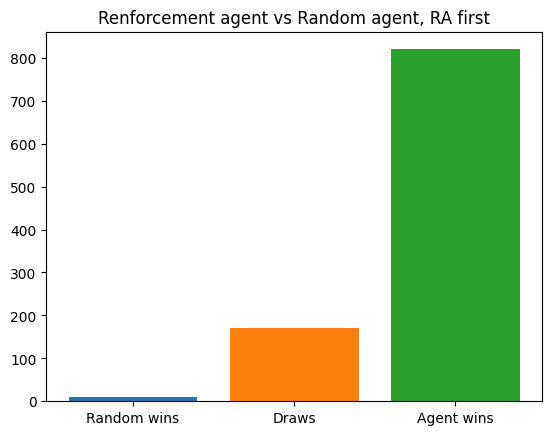

In [934]:
bar1 = plt.bar("Random wins", agent_first.count('x'), label="hello")
bar2 = plt.bar("Draws", agent_first.count('t'))
bar3 = plt.bar("Agent wins", agent_first.count('o'))
plt.title("Renforcement agent vs Random agent, RA first")
plt.add

Text(0.5, 1.0, 'Renforcement agent vs Random agent, Random first')

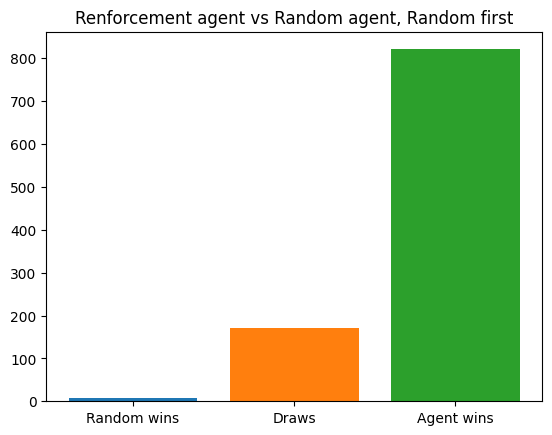

In [936]:
plt.bar("Random wins", random_first.count('x'))
plt.bar("Draws", random_first.count('t'))
plt.bar("Agent wins", random_first.count('o'))
plt.title("Renforcement agent vs Random agent, Random first")